In [ ]:
import os
import json
import cv2
import random
import yaml
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# Extract frames from data

## Create dataset

In [ ]:
# --- Configuration ---
BASE_DATASET_DIR = 'observing/train'
OUTPUT_DIR = 'yolo_dataset'
TRAIN_RATIO = 0.7
CLASS_ID = 0
CLASS_NAME = 'target_object'

In [ ]:
def convert_to_yolo(box, img_w, img_h):
    """
    Converts (x1, y1, x2, y2) absolute pixel coordinates to
    YOLO's (x_center_norm, y_center_norm, width_norm, height_norm) format.
    """
    try:
        x1, y1, x2, y2 = float(box[0]), float(box[1]), float(box[2]), float(box[3])
        img_w, img_h = float(img_w), float(img_h)

        dw = 1.0 / img_w
        dh = 1.0 / img_h

        x_center = (x1 + x2) / 2.0
        y_center = (y1 + y2) / 2.0
        width = x2 - x1
        height = y2 - y1

        x_center_norm = x_center * dw
        y_center_norm = y_center * dh
        width_norm = width * dw
        height_norm = height * dh

        return (x_center_norm, y_center_norm, width_norm, height_norm)
    except Exception as e:
        print(f"Error in coordinate conversion: {e}")
        return None

In [ ]:
def process_frame(cap, frame_num, boxes, video_id, split_name, img_w, img_h, output_base_dir):
    """
    Read a frame and save it along with its YOLO annotations.
    """

    output_images_dir = os.path.join(output_base_dir, 'images', split_name)
    output_labels_dir = os.path.join(output_base_dir, 'labels', split_name)

    # Capture the specific frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()

    if not ret:
        print(f" Warning: Frame {frame_num} of video {video_id} could not be read from video.")
        return

    # Specify file paths
    file_basename = f"{video_id}_frame_{frame_num:06d}"
    image_path = os.path.join(output_images_dir, f"{file_basename}.jpg")
    label_path = os.path.join(output_labels_dir, f"{file_basename}.txt")

    # Save images
    cv2.imwrite(image_path, frame)

    # Save YOLO annotations
    with open(label_path, 'w') as f:
        for box in boxes:
            # Convert to YOLO format
            yolo_coords = convert_to_yolo(box, img_w, img_h)

            if yolo_coords:
                x_c, y_c, w, h = yolo_coords
                # Write to label file
                f.write(f"{CLASS_ID} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n")

In [ ]:
def create_yaml_file(output_dir, class_name):
    """Creates the dataset.yaml file required by YOLO."""

    # Get absolute paths for the YAML file
    train_path = os.path.abspath(os.path.join(output_dir, 'images', 'train'))
    val_path = os.path.abspath(os.path.join(output_dir, 'images', 'val'))

    yaml_content = {
        'train': train_path,
        'val': val_path,
        'nc': 1,  # number of classes
        'names': [class_name]  # list of class names
    }

    yaml_path = os.path.join(output_dir, 'dataset.yaml')

    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_content, f, default_flow_style=False, sort_keys=False)

    print(f"\nSuccessfully created {yaml_path}")
    print("This file points to your training and validation data.")

In [ ]:
def build_dataset():
    annotations_file = os.path.join(BASE_DATASET_DIR, 'annotations', 'annotations.json')
    samples_dir = os.path.join(BASE_DATASET_DIR, 'samples')

    if not os.path.exists(annotations_file):
        print(f"Error: Annotation file not found at {annotations_file}")
        return

    if not os.path.exists(samples_dir):
        print(f"Error: Samples directory not found at {samples_dir}")
        return

    # Create all output directories
    os.makedirs(os.path.join(OUTPUT_DIR, 'images', 'train'), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, 'images', 'val'), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, 'labels', 'train'), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, 'labels', 'val'), exist_ok=True)

    # Load all annotation records
    print("Loading annotations...")
    with open(annotations_file, 'r') as f:
        try:
            all_video_records = json.load(f)
        except json.JSONDecodeError as e:
            print(f"Error: Could not parse annotations.json. Invalid JSON: {e}")
            return

    if not isinstance(all_video_records, list):
         print(f"Error: Expected annotations.json to contain a list of video records.")
         return

    random.seed(42) # Use a fixed seed for reproducible splits

    print("Processing videos and splitting frames...")
    # Loop over each video file
    for record in tqdm(all_video_records, desc="Processing Videos"):
        video_id = record['video_id']
        video_path = os.path.join(samples_dir, video_id, 'drone_video.mp4')

        if not os.path.exists(video_path):
            print(f"Warning: Video file not found, skipping: {video_path}")
            continue

        # 1. Group all annotations by frame number for this video.
        frames_to_process = {}
        for interval in record.get('annotations', []):
            for bbox_data in interval.get('bboxes', []):
                try:
                    frame_num = int(bbox_data['frame'])
                    box = (
                        int(bbox_data['x1']),
                        int(bbox_data['y1']),
                        int(bbox_data['x2']),
                        int(bbox_data['y2'])
                    )

                    if frame_num not in frames_to_process:
                        frames_to_process[frame_num] = []
                    frames_to_process[frame_num].append(box)
                except KeyError as e:
                    print(f"Warning: Missing key {e} in bbox data for {video_id}, skipping box.")
                except Exception as e:
                    print(f"Warning: Error processing bbox data for {video_id}: {e}, skipping box.")

        if not frames_to_process:
            continue

        # 2. Open video and get its properties
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video {video_path}, skipping.")
            continue

        video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        if video_width == 0 or video_height == 0:
            print(f"Error: Could not get dimensions for video {video_path}, skipping.")
            cap.release()
            continue

        # 3. THIS IS THE SPLIT: Shuffle the list of frames *for this video*
        frame_items = list(frames_to_process.items())

        split_index = int(len(frame_items) * TRAIN_RATIO)
        train_frames = frame_items[:split_index]
        val_frames = frame_items[split_index:]

        # 4. Process and save frames to their respective splits
        for frame_num, boxes in train_frames:
            process_frame(cap, frame_num, boxes, video_id, 'train', video_width, video_height, OUTPUT_DIR)

        for frame_num, boxes in val_frames:
            process_frame(cap, frame_num, boxes, video_id, 'val', video_width, video_height, OUTPUT_DIR)

        cap.release()

    # Create the final dataset.yaml file
    create_yaml_file(OUTPUT_DIR, CLASS_NAME)

    print("\n--- Dataset generation complete! ---")
    print(f"Your YOLO dataset is ready in: {os.path.abspath(OUTPUT_DIR)}")

In [ ]:
build_dataset()

Loading annotations...
--- WARNING: Splitting frames, not videos. ---
This can lead to data leakage and artificially high validation metrics.
--------------------------------------------------
Processing videos and splitting frames...


Processing Videos: 100%|██████████| 14/14 [10:08<00:00, 43.47s/it]


Successfully created yolo_dataset\dataset.yaml
This file points to your training and validation data.

--- Dataset generation complete! ---
Your YOLO dataset is ready in: c:\Learning\AIO_Projects\Zalo_AI\yolo_dataset


## Visualize data

In [ ]:
def denormalize_yolo(yolo_coords, img_w, img_h):
    """
    Converts YOLO's (x_center_norm, y_center_norm, width_norm, height_norm)
    back to (x1, y1, x2, y2) absolute pixel coordinates.
    """
    x_c_norm, y_c_norm, w_norm, h_norm = yolo_coords

    # Calculate pixel values from normalized values
    box_w = w_norm * img_w
    box_h = h_norm * img_h
    x_c = x_c_norm * img_w
    y_c = y_c_norm * img_h

    # Calculate top-left corner (x1, y1)
    x1 = int(x_c - (box_w / 2))
    y1 = int(y_c - (box_h / 2))

    # Calculate bottom-right corner (x2, y2)
    x2 = int(x_c + (box_w / 2))
    y2 = int(y_c + (box_h / 2))

    return (x1, y1, x2, y2)

In [ ]:
def visualize_annotation(image_path, label_path):
    """
    Loads an image and its label, draws the bounding boxes, and displays it
    """

    # Load the image using OpenCV
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return

    img_h, img_w, _ = image.shape

    if not os.path.exists(label_path):
        print(f"Warning: No label file found at {label_path}")
    else:
        # Read the label file
        with open(label_path, 'r') as f:
            for line in f:
                try:
                    # Parse the YOLO coordinates
                    parts = line.strip().split()
                    yolo_coords = [float(p) for p in parts[1:]]

                    # Denormalize coordinates
                    x1, y1, x2, y2 = denormalize_yolo(yolo_coords, img_w, img_h)

                    # --- Draw on the image ---
                    # Draw the bounding box (in green, BGR format)
                    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

                except Exception as e:
                    print(f"Error processing line '{line}': {e}")

    # --- Display the image in the notebook ---
    print(f"Displaying: {os.path.basename(image_path)}")

    # 1. Convert from BGR (OpenCV) to RGB (Matplotlib)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 2. Set figure size to be reasonable
    plt.figure(figsize=(10, 10))

    # 3. Display the image
    plt.imshow(image_rgb)

    # 4. Hide the axes
    plt.axis('off')

    # 5. Show the plot
    plt.show()

Displaying: Backpack_0_frame_003483.jpg


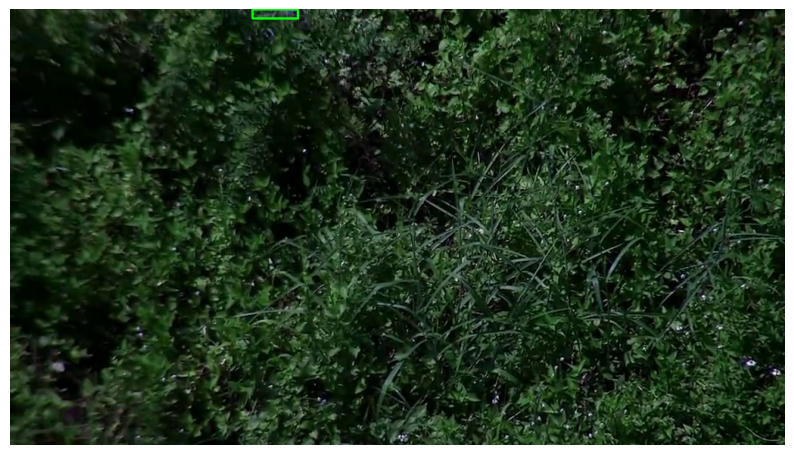

In [ ]:
YOLO_DATASET_DIR = OUTPUT_DIR
SPLIT_TO_CHECK = 'val'  # Change to 'train' to check training

images_dir = os.path.join(YOLO_DATASET_DIR, 'images', SPLIT_TO_CHECK)
labels_dir = os.path.join(YOLO_DATASET_DIR, 'labels', SPLIT_TO_CHECK)


# Get a list of all images
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

# Pick a random image
random_image_name = 'Backpack_0_frame_003483.jpg'
image_path = os.path.join(images_dir, random_image_name)

# Construct the corresponding label path
label_name = os.path.splitext(random_image_name)[0] + '.txt'
label_path = os.path.join(labels_dir, label_name)
visualize_annotation(image_path, label_path)

# Training YOLO11

In [ ]:
from ultralytics import YOLO

In [ ]:
model = YOLO('yolo11n.pt')

In [ ]:
results = model.train(
        data='yolo_dataset/dataset.yaml',
        epochs=50,
        imgsz=640,
        batch=64,
        lr0=0.001,

        # Add more augmentation
        mixup=0.1,
        degrees=15.0,
        shear=5.0,

        name='drone_training'
    )

New https://pypi.org/project/ultralytics/8.3.223 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.14 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5070, 12227MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.2, data=yolo_dataset/dataset.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=drone_training_heavy_aug

# Inferencing

In [ ]:
MODEL_PATH = 'runs/detect/drone_training/weights/last.pt'

TEST_DATA_DIR = 'observing/public_test/samples/'

OUTPUT_FILE = 'predictions.json'

CONFIDENCE_THRESHOLD = 0.25

In [ ]:
def run_inference():
    """
    Runs YOLO11 inference on test videos and saves the results
    in the required JSON format.
    """

    # Load the trained model
    try:
        model = YOLO(MODEL_PATH)
        print(f"Successfully loaded model from {MODEL_PATH}")
    except Exception as e:
        print(f"Error: Could not load model from {MODEL_PATH}")
        print(e)
        return

    # List to hold all final predictions
    all_predictions = []

    # Find all video folders in the test directory
    try:
        video_folders = sorted([f for f in os.listdir(TEST_DATA_DIR) if os.path.isdir(os.path.join(TEST_DATA_DIR, f))])
    except FileNotFoundError:
        print(f"Error: Test data directory not found at: {TEST_DATA_DIR}")
        return

    if not video_folders:
        print(f"Error: No video folders found in {TEST_DATA_DIR}")
        return

    print(f"Found {len(video_folders)} videos to process...")

    # Use tqdm for a progress bar over the videos
    for video_folder_name in tqdm(video_folders, desc="Processing videos"):
        video_path = os.path.join(TEST_DATA_DIR, video_folder_name, 'drone_video.mp4')

        if not os.path.exists(video_path):
            print(f"Warning: 'drone_video.mp4' not found in {video_folder_name}, skipping.")
            continue

        # Temporary list to hold all bboxes for THIS video
        video_bboxes = []

        try:
            # Run prediction on the video
            # stream=True to save memory (processes frame by frame)
            # conf=... to filter out weak detections
            # verbose=False to avoid printing logs for every frame
            results_generator = model.predict(
                video_path,
                stream=True,
                conf=CONFIDENCE_THRESHOLD,
                verbose=False
            )

            # Loop over each frame in the video
            # Use enumerate to get the frame index (frame_idx)
            for frame_idx, results in enumerate(results_generator):

                # Get bounding boxes in [x1, y1, x2, y2] format
                # Move to CPU and numpy for processing
                xyxy_boxes = results.boxes.xyxy.cpu().numpy()

                if len(xyxy_boxes) == 0:
                    continue # No detections in this frame

                # Loop over each detected box in the frame
                for box in xyxy_boxes:
                    x1, y1, x2, y2 = box

                    # Create the bbox object in the required format
                    bbox_data = {
                        "frame": frame_idx,
                        "x1": int(round(x1)),
                        "y1": int(round(y1)),
                        "x2": int(round(x2)),
                        "y2": int(round(y2))
                    }
                    video_bboxes.append(bbox_data)

        except Exception as e:
            print(f"Error while processing video {video_path}: {e}")
            continue # Move on to the next video

        # --- BUILD THE JSON STRUCTURE ---
        # "detections": [ { "bboxes": [...] } ]
        # OR "detections": [] if nothing was found

        detections_list = []
        if len(video_bboxes) > 0:
            # If we have detections, nest them in the format
            detections_list.append({"bboxes": video_bboxes})
        # If 'video_bboxes' is empty, 'detections_list' will remain []
        # This matches your "drone_video_002" example

        # Create the final JSON object for this video
        final_video_obj = {
            "video_id": video_folder_name,
            "detections": detections_list
        }
        all_predictions.append(final_video_obj)

    # After processing all videos, save the final JSON file
    try:
        print(f"\nSaving all {len(all_predictions)} video predictions to {OUTPUT_FILE}...")
        with open(OUTPUT_FILE, 'w') as f:
            json.dump(all_predictions, f, indent=4)
        print("Inference complete.")
    except Exception as e:
        print(f"Error: Could not write output JSON file: {e}")

if __name__ == "__main__":
    run_inference()

Successfully loaded model from runs/detect/drone_training_heavy_aug/weights/last.pt
Found 6 videos to process...


Processing videos: 100%|██████████| 6/6 [04:18<00:00, 43.14s/it]


Saving all 6 video predictions to predictions_heavy_aug_latest.json...
Inference complete.


In [ ]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. Using GPU for training.")